## Description

Since this competition doesn't provide enough training samples for us to develop our models, I'm trying to reproduce the kaggle dataset to make sure that I follow the same process to generate the training samples.

However, I failed to reproduce the kaggle dataset.
I refer to monoto's [notebook](https://www.kaggle.com/code/motono0223/sdip-example-exec-stable-diffusion-2) and the official [script](https://github.com/Stability-AI/stablediffusion/blob/main/scripts/txt2img.py) to develop the following code.

## CFG

In [1]:
!pip install --upgrade diffusers transformers -q

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path
import torch
from diffusers import StableDiffusionPipeline
from transformers import pipeline
from pytorch_lightning import seed_everything


from kaggle_secrets import UserSecretsClient


class CFG:
    device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 50
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_guidance_scale = 9
    data_dir = Path("/kaggle/input/stable-diffusion-image-to-prompts")
    output_dir = Path("./images")
    
CFG.output_dir.mkdir(parents=True, exist_ok=True)
seed_everything(CFG.seed)

42

In [3]:
user_secrets = UserSecretsClient()
secret_hf_token = user_secrets.get_secret("hf_secret")

## Image Generation Model

In [4]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token=secret_hf_token, guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Keyword arguments {'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


In [5]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        height=768,
        width=768,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]
    return image

## Generate Image

In [6]:
prompts = pd.read_csv(CFG.data_dir / "prompts.csv")
for i, row in prompts.iterrows():
    imgid = row["imgId"]
    prompt = row["prompt"]
    img = generate_image(prompt, image_gen_model)
    img.save(CFG.output_dir / f"{imgid}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Compare

In [7]:
filenames = prompts["imgId"].to_list()

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def display_images_in_grid(img_dir, filenames):
    # Get all the image files in the directory that end with .png
    images = [f"{filename}.png" for filename in filenames]

    # Create a 2x4 grid
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))

    # Flatten the axes array
    axes = axes.flatten()

    # Display the images
    for i in range(len(images)):
        # Load the image
        image_path = os.path.join(img_dir, images[i])
        image = Image.open(image_path)

        # Resize the image to fit the grid
        image = image.resize((200, 200))

        # Convert the PIL image to a numpy array
        image_array = np.asarray(image)

        # Display the image on the grid
        axes[i].imshow(image_array)
        axes[i].axis('off')
        
        axes[i].text(
            0.5, -0.1, filenames[i],
            transform=axes[i].transAxes,
            ha='center'
        )

    # Show the grid
    plt.tight_layout()
    plt.show()

### Kaggle Dataset

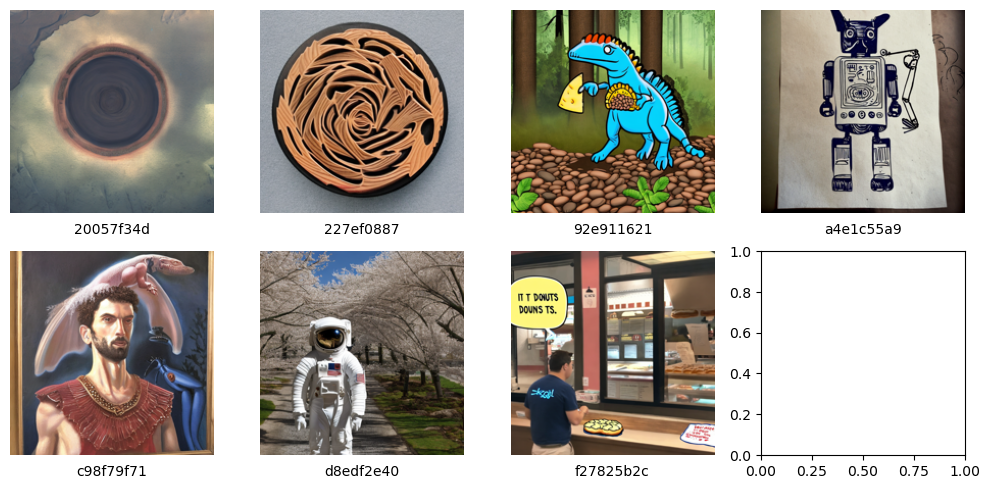

In [9]:
display_images_in_grid(str(CFG.data_dir / "images"), filenames)

### Generated Ones

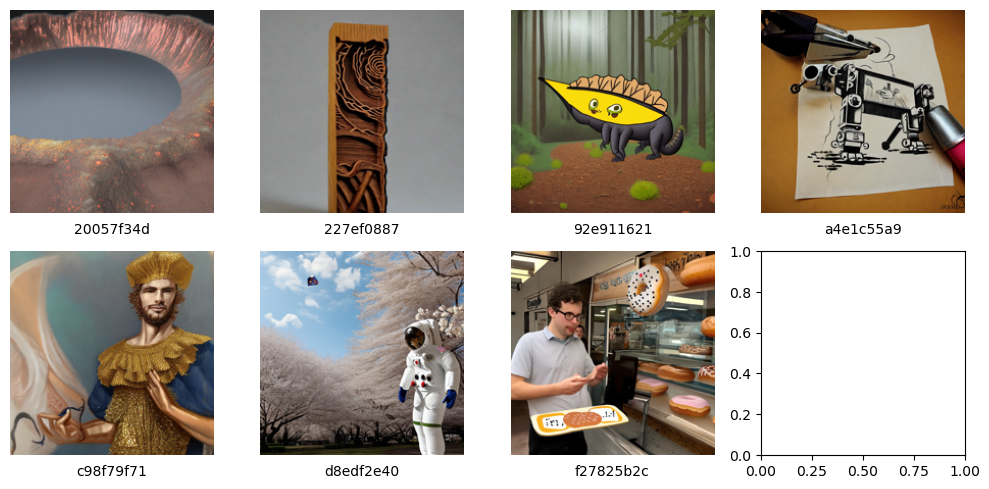

In [10]:
display_images_in_grid(str(CFG.output_dir), filenames)